### Notes and References
None yet.




In [0]:
%matplotlib inline
#@markdown ###First Cell 
#@markdown *Please paste this cell into any colab notebook for this project.* <br>
#@markdown ***
#@markdown **Contents**: Contents. <br>
#@markdown ***
#@markdown Major Edit History: 
#@markdown - Author, Date: Created as copy of Old Notebook (`Old Title`).
#@markdown ***
#@markdown <br> 
#@markdown Please change `FIELDDAY_DIR` if it is located differently in your drive. This cell will error if `FIELDDAY_DIR` is incorrect.
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Change working directory
import os
FIELDDAY_DIR = '/content/drive/My Drive/Field Day' #@param {type:"string"}
INCLUDE_DIR = '/content/drive/My Drive/Field Day/Research and Writing Projects/OGDUtils' #@param (type:"string")
PROJECT_DIR = os.path.join(FIELDDAY_DIR,'Research and Writing Projects/2019 Using Jo Wilder to Predict English Language Skill')
JUPYTER_DIR = os.path.join(PROJECT_DIR,'Colab')
os.chdir(JUPYTER_DIR)
print(f'---\nCWD: {os.getcwd()}')

#@markdown Change pandas `max_rows` and `max_columns`
import pandas as pd
pd.options.display.max_columns = 100 #@param {type:"integer"}
#pd.options.display.max_columns = 1000
pd.options.display.max_rows = 60 #@param {type:"integer"}

#@markdown *Note: There may be other variables to manually change. Look the "Set Variables" section.*

# import utils
import sys
sys.path.append(INCLUDE_DIR)
#sys.path.append('.')
import utils

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
---
CWD: /content/drive/My Drive/Field Day/Research and Writing Projects/2019 Using Jo Wilder to Predict English Language Skill/Colab


### Imports

In [0]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
import jowilder_utils as jw_util
import feature_utils as feat_util
import urllib.request
from google.colab import files
from io import BytesIO
from math import ceil
from matplotlib import pyplot as plt
from scipy import stats
from Workflow import Workflow
from zipfile import ZipFile
import importlib
importlib.reload(feat_util)
importlib.reload(jw_util)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<module 'jowilder_utils' from '/content/drive/My Drive/Field Day/Research and Writing Projects/OGDUtils/jowilder_utils.py'>

## Import CSV

In [0]:
csv_reldir = "Output Data" #@param {type:"string"}
csv_fname = "JM_202006041215_filtered_obj_feats.csv" #@param {type:"string"}
csv_path = os.path.join(csv_reldir, csv_fname)
print('Open from:', csv_path)
print('Other files in dir:', ''.join([
        f'\n{f}' for f in os.listdir(csv_reldir) if f.endswith('sv')]))

Open from: Output Data/JM_202006041215_filtered_obj_feats.csv
Other files in dir: 
JM_202006041215_filtered_obj_feats.csv
JM_202006080931_filtered_obj_feats.csv
JM_202006090933_filtered_obj_feats.csv


In [0]:
df = pd.read_csv(csv_path, comment='#', index_col=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (29,69,75,77,85,93,101,109) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Preprocessing

In [0]:
# map onext_int feats to int categories
onext_int_feats = [c for c in df if c.endswith('onext_int')]
df.loc[:,onext_int_feats] = df.loc[:,onext_int_feats].astype('int').astype('category')

# get list of numeric and categorical feats
numerical_feats_suffix = ['ifirst_enc_duration','inum_enc',
                   'ifirst_enc_avg_wps','ifirst_enc_var_wps','ifirst_enc_avg_tbps','ifirst_enc_var_tbps'
                   'ocount_clicks','omeaningful_action_count','ocount_notebook_uses','otime_to_next_obj']
categorical_feats_suffix = ['onext_int']
numeric_feats = []
for s in numerical_feats_suffix:
    numeric_feats.extend([c for c in df if c.endswith(s)])
categorical_feats = []
for s in categorical_feats_suffix:
    categorical_feats.extend([c for c in df if c.endswith(s)])
use_feats = numeric_feats + categorical_feats

In [0]:
len(use_feats)

1265

In [0]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# set X and y
X = df[use_feats]
y0,y1,y2 = df["R0_quiz_response"].astype('category'), df["R1_quiz_response"].astype('category'), df["R2_quiz_response"].astype('category')
y = y0

# make sure X has no nulls
print('X has nulls?', X.isnull().values.any())
X.describe()

X has nulls? False


,int0_ifirst_enc_duration,int100_ifirst_enc_duration,int101_ifirst_enc_duration,int102_ifirst_enc_duration,int103_ifirst_enc_duration,int104_ifirst_enc_duration,int105_ifirst_enc_duration,int106_ifirst_enc_duration,int107_ifirst_enc_duration,int108_ifirst_enc_duration,int109_ifirst_enc_duration,int10_ifirst_enc_duration,int110_ifirst_enc_duration,int111_ifirst_enc_duration,int112_ifirst_enc_duration,int113_ifirst_enc_duration,int114_ifirst_enc_duration,int115_ifirst_enc_duration,int116_ifirst_enc_duration,int117_ifirst_enc_duration,int118_ifirst_enc_duration,int119_ifirst_enc_duration,int11_ifirst_enc_duration,int120_ifirst_enc_duration,int121_ifirst_enc_duration,int122_ifirst_enc_duration,int123_ifirst_enc_duration,int124_ifirst_enc_duration,int125_ifirst_enc_duration,int126_ifirst_enc_duration,int127_ifirst_enc_duration,int128_ifirst_enc_duration,int129_ifirst_enc_duration,int12_ifirst_enc_duration,int130_ifirst_enc_duration,int131_ifirst_enc_duration,int132_ifirst_enc_duration,int133_ifirst_enc_duration,int134_ifirst_enc_duration,int135_ifirst_enc_duration,int136_ifirst_enc_duration,int137_ifirst_enc_duration,int138_ifirst_enc_duration,int139_ifirst_enc_duration,int13_ifirst_enc_duration,int140_ifirst_enc_duration,int141_ifirst_enc_duration,int142_ifirst_enc_duration,int143_ifirst_enc_duration,int144_ifirst_enc_duration,...,obj37_otime_to_next_obj,obj38_otime_to_next_obj,obj39_otime_to_next_obj,obj3_otime_to_next_obj,obj40_otime_to_next_obj,obj41_otime_to_next_obj,obj42_otime_to_next_obj,obj43_otime_to_next_obj,obj44_otime_to_next_obj,obj45_otime_to_next_obj,obj46_otime_to_next_obj,obj47_otime_to_next_obj,obj48_otime_to_next_obj,obj49_otime_to_next_obj,obj4_otime_to_next_obj,obj50_otime_to_next_obj,obj51_otime_to_next_obj,obj52_otime_to_next_obj,obj53_otime_to_next_obj,obj54_otime_to_next_obj,obj55_otime_to_next_obj,obj56_otime_to_next_obj,obj57_otime_to_next_obj,obj58_otime_to_next_obj,obj59_otime_to_next_obj,obj5_otime_to_next_obj,obj60_otime_to_next_obj,obj61_otime_to_next_obj,obj62_otime_to_next_obj,obj63_otime_to_next_obj,obj64_otime_to_next_obj,obj65_otime_to_next_obj,obj66_otime_to_next_obj,obj67_otime_to_next_obj,obj68_otime_to_next_obj,obj69_otime_to_next_obj,obj6_otime_to_next_obj,obj70_otime_to_next_obj,obj71_otime_to_next_obj,obj72_otime_to_next_obj,obj73_otime_to_next_obj,obj74_otime_to_next_obj,obj75_otime_to_next_obj,obj76_otime_to_next_obj,obj77_otime_to_next_obj,obj78_otime_to_next_obj,obj79_otime_to_next_obj,obj7_otime_to_next_obj,obj8_otime_to_next_obj,obj9_otime_to_next_obj
count,13935.000000,13935.000000,13935.0,13935.0,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.0,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.0,13935.0,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.0,13935.000000,13935.000000,13935.0,13935.0,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,...,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.00000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000,13935.000000
mean,12.571657,0.058971,0.0,0.0,1.328948,0.093135,2.027044,0.266225,1.427717,0.636814,0.079106,9.577445,0.577775,0.563843,0.0,0.284852,0.275435,0.484150,1.178378,0.278256,0.444189,0.187610,

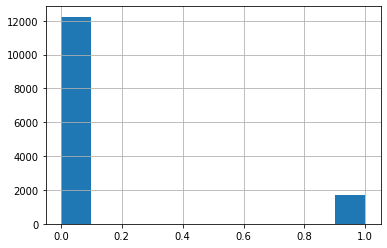

In [0]:
y.hist()

In [0]:

# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler()),
#     ])
# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore')),
#     ])
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_feats),
#         ('cat', categorical_transformer, categorical_feats)])

In [0]:
'''make preprocessor. ColumnTransformer takes in List of 
(name, transformer, columns) tuples specifying the transformer objects to be 
applied to subsets of the data. Columns need to be an array of col indexes because
oversampler only outputs np arrays, not pd dataframes'''
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [X.columns.get_loc(c) for c in numeric_feats]),
#        ('cat', OneHotEncoder(categories=np.array([189]*80), handle_unknown='error'), categorical_feats),
        ('cat', OneHotEncoder(handle_unknown='ignore'), [X.columns.get_loc(c) for c in categorical_feats])])

## Multinomial Regression

In [0]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
model_dict = {}
for solver in ['saga']: # ['newton-cg', 'sag', 'saga', 'lbfgs']:
    penalties = ['l2']
    # if solver == 'saga':
    #     penalties = ['l1', 'l2']
    for penalty in penalties:
        model_name = f'{penalty} {solver}'
        print(f'Running {model_name}.')

        classifier = LogisticRegression(max_iter=500, multi_class='multinomial', solver=solver, penalty=penalty)
                # clf = Pipeline(steps=[('preprocessor', preprocessor),
                #             ('classifier', classifier)],
                #     verbose=True)
        # add oversampler to front of the pipeline. use "nake_pipeliine" because
        # RandomOverSampler is not compatible with sklearn pipelines.
        clf = make_pipeline(RandomOverSampler(), preprocessor, classifier)



        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        clf.fit(X_train, y_train)
        print("model score: %.3f" % clf.score(X_test, y_test))
        model_dict[model_name] = clf

Running l2 saga.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


model score: 0.578


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


# Model Evaluation

dimension y_prob: (2787, 2)
dimension y_test: (2787,)


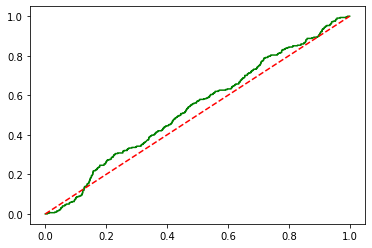

ROC-AUC Score: 0.46514971209698


In [0]:
from sklearn.metrics import roc_auc_score, roc_curve
y_prob = clf.predict_proba(X_test)
print(f"dimension y_prob: {y_prob.shape}")
print(f"dimension y_test: {y_test.shape}")
fpr, tpr, thres = roc_curve(y_test, y_prob[:,1])
plt.plot(fpr, tpr, color='green')
plt.plot([0,1],[0,1], color='red', linestyle='--')
plt.show()
roc_auc = roc_auc_score(y_test, y_prob[:,0], multi_class='ovr', average='macro')
print(f"ROC-AUC Score: {roc_auc}")

In [0]:
X

In [0]:
from sklearn import set_config
set_config()
clf